In [1]:
from vqe_functionss import*


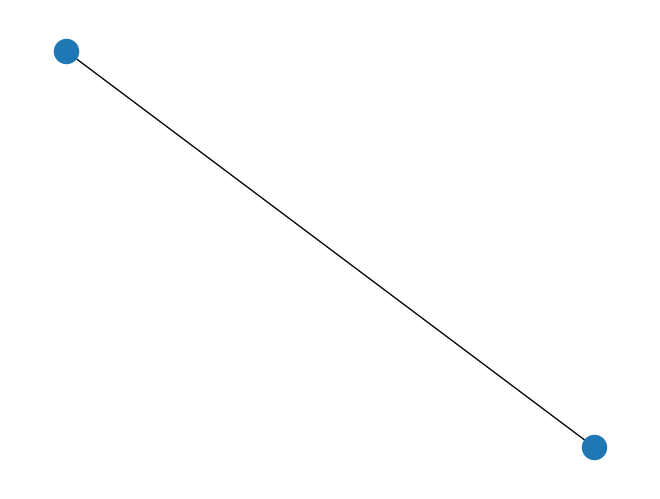

In [2]:
n_qubits = 2
g = get_line_graph(n_qubits)
nx.draw(g)

In [3]:
h = get_h_op(g, hz=.2)
print(h)

SparsePauliOp(['IX', 'IZ', 'XI', 'ZI', 'IZ', 'ZI', 'ZZ'],
              coeffs=[-0.5+0.j, -0.2+0.j, -0.5+0.j, -0.2+0.j,  0. +0.j, -0. +0.j, -1. +0.j])


In [4]:
from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem

In [5]:
initial_state = Statevector.from_label('10')
final_time = 1.6

problem = TimeEvolutionProblem(h, initial_state=initial_state, time=final_time)

In [19]:
from qiskit_algorithms import TrotterQRTE
from qiskit.primitives import Estimator
H = get_h_op(g)
num_timesteps = 120
trotter = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator())


In [20]:
magnetization_op = SparsePauliOp.from_sparse_list([('Z', [i], 1.) for i in range(n_qubits)], num_qubits=n_qubits)
correlation_op = SparsePauliOp.from_sparse_list([('ZZ', [i, i+1], 1.) for i in range(n_qubits-1)], num_qubits=n_qubits) / (n_qubits-1)

In [21]:
final_time = 30.
initial_state = Statevector.from_label('10')
problem = TimeEvolutionProblem(h, initial_state=initial_state, time=final_time, aux_operators=[h, magnetization_op, correlation_op])

In [22]:
result = trotter.evolve(problem)

In [23]:
observables = np.array(np.array(result.observables)[:, :, 0])


Text(0.5, 0.98, 'Observable evolution')

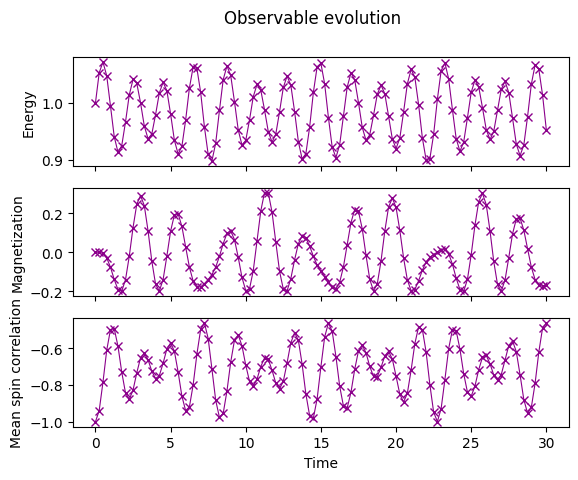

In [24]:
fig, axes = plt.subplots(3, sharex=True)
times = np.linspace(0, final_time, num_timesteps + 1) # includes initial state
axes[0].plot(times, observables[:, 0], label='First order', marker='x', c='darkmagenta', ls='-', lw=.8)
axes[1].plot(times, observables[:, 1], label='First order', marker='x', c='darkmagenta', ls='-', lw=.8)
axes[2].plot(times, observables[:, 2], label='First order', marker='x', c='darkmagenta', ls='-', lw=.8)
axes[0].set_ylabel('Energy')
axes[1].set_ylabel('Magnetization')
axes[2].set_ylabel('Mean spin correlation')
axes[2].set_xlabel('Time')
fig.suptitle('Observable evolution')

In [25]:
import scipy as sc

H_array = H.to_matrix()

In [26]:
exact_times = np.linspace(0, final_time, 101)

In [27]:
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]

In [29]:
exact_energy = np.real([sv.expectation_value(H) for sv in exact_evolution])
exact_magnetization = np.real([sv.expectation_value(magnetization_op) for sv in exact_evolution])
exact_correlation = np.real([sv.expectation_value(correlation_op) for sv in exact_evolution])

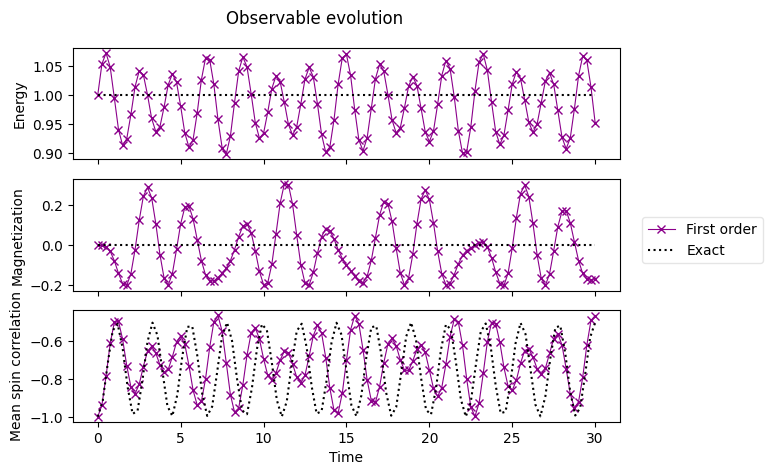

In [30]:
axes[0].plot(exact_times, exact_energy, c='k', ls=':', label='Exact')
axes[1].plot(exact_times, exact_magnetization, c='k', ls=':', label='Exact')
axes[2].plot(exact_times, exact_correlation, c='k', ls=':', label='Exact')
legend = fig.legend(*axes[0].get_legend_handles_labels(), bbox_to_anchor=(1., .5), loc='center left', framealpha=.5)
fig.tight_layout()
fig

In [31]:
from qiskit.synthesis import SuzukiTrotter

trotter = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=num_timesteps, estimator=Estimator())
problem= TimeEvolutionProblem(H, initial_state=initial_state, time=final_time, aux_operators=[H, magnetization_op, correlation_op])
result = trotter.evolve(problem)
observables_order4 = np.array(np.array(result.observables)[:, :, 0], dtype=np.float64)

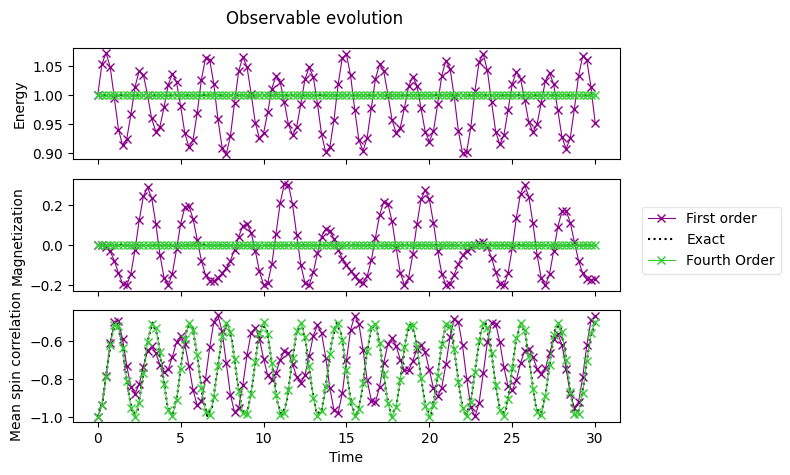

In [32]:
axes[0].plot(times, observables_order4[:, 0], label='Fourth Order', marker='x', c='limegreen', ls='-', lw=.8)
axes[1].plot(times, observables_order4[:, 1], label='Fourth Order', marker='x', c='limegreen', ls='-', lw=.8)
axes[2].plot(times, observables_order4[:, 2], label='Fourth Order', marker='x', c='limegreen', ls='-', lw=.8)

legend.remove()
legend = fig.legend(*axes[0].get_legend_handles_labels(), bbox_to_anchor=(1., .5), loc='center left', framealpha=.5)
fig